In [5]:
pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K  

import tqdm


import math

os.environ["CUDA_VISIBLE_DEVICES"]="2"
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

per_process_gpu_memory_fraction: 0.333

## dataset read and processing

In [7]:
original_data=pd.read_hdf("/Users/bolit/OneDrive/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/content/events_anomalydetection_v2.features.h5")
features_sig=original_data.query("label == 1")
features_bg=original_data.query("label == 0")


features_bg2=pd.read_hdf("/Users/bolit/OneDrive/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/content/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [8]:
features_sig

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
1000000,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635600,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901,1.0
1000001,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801,1.0
1000002,420.975006,-1739.790039,281.553986,93.665802,77.925797,10.605900,6.916510,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300,1.0
1000003,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.179993,102.625000,53.422699,1.0
1000004,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


In [9]:
alpha = 0.1

def load_dataT21(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

def load_dataT32(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"] 
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau32jOne", "tau32jTwo"]]
    return dataset.to_numpy()

def load_data_more(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    
    #Masa ya al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #tau32
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]   
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    return dataset.to_numpy()

column_labelsT21 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", 
    r"$\tau_{2,1}^{J_2}$",
]

column_labelsT32 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{3,2}^{J_1}$", 
    r"$\tau_{3,2}^{J_2}$",
]

In [10]:
dataset_bgT21=load_dataT21(features_bg)
dataset_bg2T21=load_dataT21(features_bg2)
dataset_sigT21=load_dataT21(features_sig)

dataset_bgT32=load_dataT32(features_bg)
dataset_bg2T32=load_dataT32(features_bg2)
dataset_sigT32=load_dataT32(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:25: SettingWithCopyWarning: 

C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]


In [11]:
dataset_bg_more=load_data_more(features_bg)
dataset_bg2_more=load_data_more(features_bg2)
dataset_sig_more=load_data_more(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\259476259.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

## data preparation CWoLa T_21

making it machine-learnable, setting params for ML methods, setting signal significance

In [12]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT21, bg2_srsbT21, sig_srsbT21 = sr_crit(dataset_bgT21), sr_crit(dataset_bg2T21), sr_crit(dataset_sigT21)

SR_background_dataT21 = dataset_bgT21[bg_srsbT21]
SB_background_dataT21 = dataset_bgT21[~bg_srsbT21]
print(~bg_srsbT21)

SR_background_simT21 = dataset_bg2T21[bg2_srsbT21]
SB_background_simT21 = dataset_bg2T21[~bg2_srsbT21]

SR_signalT21 = dataset_sigT21[sig_srsbT21]
SB_signalT21 = dataset_sigT21[~sig_srsbT21]

N_inputs = len(SR_background_dataT21.T) - 1


((SR_background_dataT21, SR_background_data_fortestT21),
 (SR_background_simT21, SR_background_sim_fortestT21),
 (SB_background_dataT21, SB_background_data_fortestT21),
 (SB_background_simT21, SB_background_sim_fortestT21),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT21, SR_background_simT21,
    SB_background_dataT21, SB_background_simT21,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT21, SB_background_simT21, SR_background_dataT21, 
                                      SR_background_simT21]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT21)*Nsig/len(SR_signalT21)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)))

n_injectionsT21 = 20
SR_signals_to_injectT21 = [None] * n_injectionsT21
SB_signals_to_injectT21 = [None] * n_injectionsT21
signals_to_testT21 = [None] * n_injectionsT21

for i in range(n_injectionsT21):
    idx = np.isin(range(len(SR_signalT21)), np.random.choice(SR_signalT21.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT21[i] = SR_signalT21[idx, :]
    signals_to_testT21[i] = SR_signalT21[~idx, :]
    
    idx = np.isin(range(len(SB_signalT21)), np.random.choice(SB_signalT21.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT21[i] = SB_signalT21[idx, :]

[False  True  True ...  True  True  True]
     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


## CWoLa T_21

With relu activation

In [13]:
#CWoLa with T21 and relu 
cwola_rocsT21 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21 = Sequential()
    model_cwolaT21.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(1, activation='sigmoid'))
    model_cwolaT21.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21 = model_cwolaT21.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21 = model_cwolaT21.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21, tpr_cwolaT21, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21)
    cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:27<27:44, 87.61s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [02:55<26:17, 87.64s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:22<24:50, 87.67s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [05:55<23:53, 89.62s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:30<22:54, 91.65s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:05<21:36, 92.62s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:38<20:08, 92.94s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:12<18:35, 92.98s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [13:45<17:03, 93.09s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:16<15:25, 92.56s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [16:46<13:45, 91.70s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:17<12:11, 91.45s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:52<10:47, 92.50s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [21:28<09:22, 93.71s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [23:01<07:47, 93.50s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [24:35<06:14, 93.65s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:08<04:40, 93.50s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [27:40<03:06, 93.02s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:19<01:34, 94.63s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\3083969201.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [30:55<00:00, 92.78s/it]


## data preparation CWoLa T_32

making it machine-learnable, setting params for ML methods, setting signal significance

In [14]:
SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT32, bg2_srsbT32, sig_srsbT32 = sr_crit(dataset_bgT32), sr_crit(dataset_bg2T32), sr_crit(dataset_sigT32)

SR_background_dataT32 = dataset_bgT32[bg_srsbT32]
SB_background_dataT32 = dataset_bgT32[~bg_srsbT32]

SR_background_simT32 = dataset_bg2T32[bg2_srsbT32]
SB_background_simT32 = dataset_bg2T32[~bg2_srsbT32]

SR_signalT32 = dataset_sigT32[sig_srsbT32]
SB_signalT32 = dataset_sigT32[~sig_srsbT32]

N_inputs = len(SR_background_dataT32.T) - 1


((SR_background_dataT32, SR_background_data_fortestT32),
 (SR_background_simT32, SR_background_sim_fortestT32),
 (SB_background_dataT32, SB_background_data_fortestT32),
 (SB_background_simT32, SB_background_sim_fortestT32),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT32, SR_background_simT32,
    SB_background_dataT32, SB_background_simT32,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT32, SB_background_simT32, SR_background_dataT32, 
                                      SR_background_simT32]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT32)*Nsig/len(SR_signalT32)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT32[0:Nsig])/len(SR_background_dataT32)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT32[0:Nsig])/len(SR_background_dataT32)))

n_injectionsT32 = 20
SR_signals_to_injectT32 = [None] * n_injectionsT32
SB_signals_to_injectT32 = [None] * n_injectionsT32
signals_to_testT32 = [None] * n_injectionsT32

for i in range(n_injectionsT32):
    idx = np.isin(range(len(SR_signalT32)), np.random.choice(SR_signalT32.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT32[i] = SR_signalT32[idx, :]
    signals_to_testT32[i] = SR_signalT32[~idx, :]
    
    idx = np.isin(range(len(SB_signalT32)), np.random.choice(SB_signalT32.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT32[i] = SB_signalT32[idx, :]

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


## CWoLa T_32

With relu activation

In [15]:
#CWoLa with T32 and relu
cwola_rocsT32 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT32)):
    
    SR_signal_to_injectT32 = SR_signals_to_injectT32[i]
    SB_signal_to_injectT32 = SB_signals_to_injectT32[i]

    signal_to_testT32 = signals_to_testT32[i]
        
    X_cwola_trainT32 = np.concatenate([SR_signal_to_injectT32, SR_background_dataT32, SB_signal_to_injectT32, SB_background_dataT32])
    Y_cwola_trainT32 = np.concatenate([np.ones(len(SR_signal_to_injectT32)), np.ones(len(SR_background_dataT32)),
                                    np.zeros(len(SB_signal_to_injectT32)), np.zeros(len(SB_background_dataT32))])
    
    X_cwola_trainT32, Y_cwola_trainT32 = shuffle(X_cwola_trainT32, Y_cwola_trainT32, )

    sbmjjT32 = X_cwola_trainT32[:,0]
    sb_critT32 = ((sbmjjT32 > SR_low - SB_width)&(sbmjjT32 <= SR_high + SB_width))
    
    X_cwola_trainT32 = X_cwola_trainT32[sb_critT32]
    Y_cwola_trainT32 = Y_cwola_trainT32[sb_critT32]
    
    w_lowT32 = 0.5*(len(SR_signal_to_injectT32) + len(SR_background_dataT32))/((X_cwola_trainT32[:,0] <= SR_low).sum())
    w_highT32 = 0.5*(len(SR_signal_to_injectT32) + len(SR_background_dataT32))/((X_cwola_trainT32[:,0] >= SR_high).sum())

    W_cwola_trainT32 = np.ones_like(Y_cwola_trainT32)
    W_cwola_trainT32[(Y_cwola_trainT32 == 0) & (X_cwola_trainT32[:,0] <= SR_low)] = w_lowT32
    W_cwola_trainT32[(Y_cwola_trainT32 == 0) & (X_cwola_trainT32[:,0] >= SR_high)] = w_highT32
    
    X_cwola_valT32 = np.concatenate([signal_to_testT32,SR_background_data_fortestT32])
    Y_cwola_valT32 = np.concatenate([np.ones(len(signal_to_testT32)),np.zeros(len(SR_background_data_fortestT32))])
    
    K.clear_session()
    model_cwolaT32 = Sequential()
    model_cwolaT32.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT32.add(Dense(64, activation='relu'))
    model_cwolaT32.add(Dense(64, activation='relu'))
    model_cwolaT32.add(Dense(1, activation='sigmoid'))
    model_cwolaT32.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT32 = model_cwolaT32.fit(X_cwola_trainT32[:,1:], Y_cwola_trainT32, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT32)

    scores_cwolaT32 = model_cwolaT32.predict(X_cwola_valT32[:,1:],batch_size=batch_size)
        
    fpr_cwolaT32, tpr_cwolaT32, _ = roc_curve(Y_cwola_valT32, scores_cwolaT32)
    cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:35<30:15, 95.53s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:09<28:17, 94.32s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 15%|████████████▎                                                                     | 3/20 [05:14<30:43, 108.47s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 20%|████████████████▍                                                                 | 4/20 [06:55<28:07, 105.45s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 25%|████████████████████▌                                                             | 5/20 [08:30<25:26, 101.78s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [10:03<23:05, 99.00s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [11:40<21:15, 98.08s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [13:14<19:21, 96.79s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [14:46<17:28, 95.35s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [16:27<16:10, 97.06s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [18:08<14:45, 98.44s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [19:47<13:09, 98.65s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [21:22<11:22, 97.46s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [22:56<09:38, 96.40s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [24:30<07:58, 95.64s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [26:08<06:25, 96.26s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [42:54<18:29, 369.98s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [44:32<09:36, 288.13s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [46:07<03:50, 230.20s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1169343743.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT32 = cwola_rocsT32.append({'fpr': fpr_cwolaT32, 'tpr': tpr_cwolaT32}, ignore_index=True)
100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [47:42<00:00, 143.13s/it]


In [16]:
 with np.errstate(divide='ignore'):
    tpr_pts = np.linspace(0, 1, 10000)
    
    # CWoLa T21
    fpr_interp = [None] * len(cwola_rocsT21)

    for i, row in cwola_rocsT21.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21 = np.median(fpr_interp, axis=0).data
    cwola_meanT21 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21 = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T32
    fpr_interp = [None] * len(cwola_rocsT32)

    for i, row in cwola_rocsT32.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT32 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT32 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT32 = np.median(fpr_interp, axis=0).data
    cwola_meanT32 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT32 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT32 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT32 = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Plotting

In [17]:
bands = {'cwola_T21': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'$T_{21}$', 'color':'blue'}),
         'cwola_T32': (cwola_maxT32, cwola_medT32, cwola_minT32, cwola_meanT32, cwola_stdT32, cwola_smeanT32, cwola_sstdT32, {'label':'$T_{32}$', 'color':'red'}),}

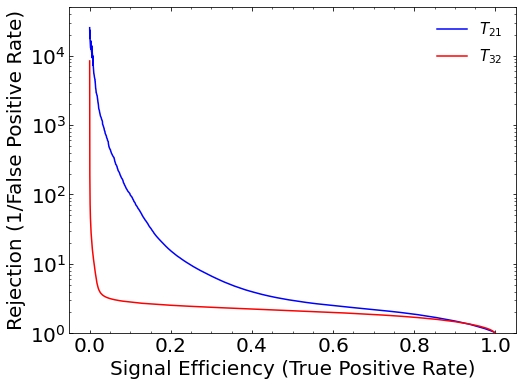

In [18]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

With T_21 is better

## selu activation

In [19]:
#CWoLa with T21 and selu 
cwola_rocsT21_selu = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21_selu = Sequential()
    model_cwolaT21_selu.add(Dense(64, input_dim=N_inputs, activation='selu')) 
    model_cwolaT21_selu.add(Dense(64, activation='selu'))
    model_cwolaT21_selu.add(Dense(64, activation='selu'))
    model_cwolaT21_selu.add(Dense(1, activation='sigmoid'))
    model_cwolaT21_selu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21_selu = model_cwolaT21_selu.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21_selu = model_cwolaT21_selu.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21_selu, tpr_cwolaT21_selu, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21_selu)
    cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
  5%|████                                                                              | 1/20 [01:44<32:56, 104.02s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 10%|████████▏                                                                         | 2/20 [03:29<31:26, 104.79s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 15%|████████████▎                                                                     | 3/20 [05:12<29:30, 104.17s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 20%|████████████████▍                                                                 | 4/20 [06:53<27:22, 102.64s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 25%|████████████████████▌                                                             | 5/20 [08:29<25:08, 100.55s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [10:08<23:19, 99.97s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 35%|████████████████████████████▋                                                     | 7/20 [11:50<21:46, 100.52s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 40%|████████████████████████████████▊                                                 | 8/20 [13:30<20:06, 100.53s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 45%|████████████████████████████████████▉                                             | 9/20 [15:12<18:27, 100.69s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 50%|████████████████████████████████████████▌                                        | 10/20 [16:52<16:46, 100.61s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 55%|████████████████████████████████████████████▌                                    | 11/20 [18:32<15:03, 100.44s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 60%|████████████████████████████████████████████████▌                                | 12/20 [20:15<13:28, 101.10s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 65%|████████████████████████████████████████████████████▋                            | 13/20 [22:00<11:57, 102.55s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 70%|████████████████████████████████████████████████████████▋                        | 14/20 [23:48<10:25, 104.18s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [25:36<08:46, 105.21s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [27:25<07:04, 106.21s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [29:09<05:17, 105.73s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [30:57<03:32, 106.32s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [32:49<01:48, 108.08s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\396052787.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_selu = cwola_rocsT21_selu.append({'fpr': fpr_cwolaT21_selu, 'tpr': tpr_cwolaT21_selu}, ignore_index=True)
100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [34:33<00:00, 103.66s/it]


## elu activation

In [20]:
#CWoLa with T21 and elu 

cwola_rocsT21_elu = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21_elu = Sequential()
    model_cwolaT21_elu.add(Dense(64, input_dim=N_inputs, activation='elu')) 
    model_cwolaT21_elu.add(Dense(64, activation='elu'))
    model_cwolaT21_elu.add(Dense(64, activation='elu'))
    model_cwolaT21_elu.add(Dense(1, activation='sigmoid'))
    model_cwolaT21_elu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21_elu = model_cwolaT21_elu.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21_elu = model_cwolaT21_elu.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21_elu, tpr_cwolaT21_elu, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21_elu)
    cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:38<31:09, 98.39s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:16<29:26, 98.11s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 15%|████████████▎                                                                     | 3/20 [05:01<28:39, 101.12s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 20%|████████████████▍                                                                 | 4/20 [06:50<27:51, 104.47s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 25%|████████████████████▌                                                             | 5/20 [08:29<25:34, 102.32s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 30%|████████████████████████▌                                                         | 6/20 [10:05<23:26, 100.47s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 35%|████████████████████████████▋                                                     | 7/20 [11:47<21:50, 100.85s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 40%|████████████████████████████████▊                                                 | 8/20 [13:31<20:22, 101.83s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 45%|████████████████████████████████████▉                                             | 9/20 [15:19<19:01, 103.76s/it]

675/675 [==============================] - 2s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 50%|████████████████████████████████████████▌                                        | 10/20 [17:09<17:35, 105.59s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 55%|████████████████████████████████████████████▌                                    | 11/20 [18:53<15:45, 105.08s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 60%|████████████████████████████████████████████████▌                                | 12/20 [20:43<14:14, 106.78s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 65%|████████████████████████████████████████████████████▋                            | 13/20 [22:25<12:17, 105.35s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 70%|████████████████████████████████████████████████████████▋                        | 14/20 [24:04<10:19, 103.27s/it]

675/675 [==============================] - 2s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [25:50<08:39, 103.99s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [27:33<06:54, 103.74s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [29:08<05:03, 101.26s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [30:52<03:24, 102.05s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [32:39<01:43, 103.37s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4036614712.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_elu = cwola_rocsT21_elu.append({'fpr': fpr_cwolaT21_elu, 'tpr': tpr_cwolaT21_elu}, ignore_index=True)
100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [34:25<00:00, 103.27s/it]


## leaky relu

In [21]:
#CWoLa with T21 and leaky relu

cwola_rocsT21_lrelu = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21_lrelu = Sequential()
    model_cwolaT21_lrelu.add(Dense(64, input_dim=N_inputs, activation='leaky_relu')) 
    model_cwolaT21_lrelu.add(Dense(64, activation='leaky_relu'))
    model_cwolaT21_lrelu.add(Dense(64, activation='leaky_relu'))
    model_cwolaT21_lrelu.add(Dense(1, activation='sigmoid'))
    model_cwolaT21_lrelu.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21_lrelu = model_cwolaT21_lrelu.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21_lrelu = model_cwolaT21_lrelu.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21_lrelu, tpr_cwolaT21_lrelu, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21_lrelu)
    cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
  5%|████                                                                              | 1/20 [01:41<32:06, 101.42s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 10%|████████▏                                                                         | 2/20 [03:23<30:34, 101.92s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:57<27:51, 98.34s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:33<25:56, 97.31s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [08:09<24:13, 96.89s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:44<22:24, 96.04s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [11:17<20:35, 95.05s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:50<18:54, 94.57s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [14:23<17:13, 93.95s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [15:56<15:36, 93.69s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [17:29<14:03, 93.68s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [19:06<12:36, 94.54s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [20:40<10:59, 94.28s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [22:12<09:22, 93.72s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [23:45<07:47, 93.49s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [25:17<06:11, 92.91s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [26:46<04:35, 91.87s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [28:19<03:04, 92.27s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [29:53<01:32, 92.70s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\785176203.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21_lrelu = cwola_rocsT21_lrelu.append({'fpr': fpr_cwolaT21_lrelu, 'tpr': tpr_cwolaT21_lrelu}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [31:23<00:00, 94.16s/it]


In [22]:
with np.errstate(divide='ignore'):
    tpr_pts = np.linspace(0, 1, 10000)
    
    # CWoLa T21 selu
    fpr_interp = [None] * len(cwola_rocsT21_selu)

    for i, row in cwola_rocsT21_selu.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21_selu = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21_selu = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21_selu = np.median(fpr_interp, axis=0).data
    cwola_meanT21_selu = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21_selu = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21_selu = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21_selu = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T21 elu
    fpr_interp = [None] * len(cwola_rocsT21_elu)

    for i, row in cwola_rocsT21_elu.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21_elu = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21_elu = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21_elu = np.median(fpr_interp, axis=0).data
    cwola_meanT21_elu = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21_elu = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21_elu = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21_elu = np.nanstd(sig_interp, axis=0).data
    
    
    # CWoLa T21 leaky relu
    fpr_interp = [None] * len(cwola_rocsT21_lrelu)

    for i, row in cwola_rocsT21_lrelu.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21_lrelu = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21_lrelu = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21_lrelu = np.median(fpr_interp, axis=0).data
    cwola_meanT21_lrelu = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21_lrelu = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21_lrelu = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21_lrelu = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [23]:
bands2 = {'cwola_T21relu': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'ReLU', 'color':'blue'}),
          'cwola_T21selu': (cwola_maxT21_selu, cwola_medT21_selu, cwola_minT21_selu, cwola_meanT21_selu, cwola_stdT21_selu, cwola_smeanT21_selu, cwola_sstdT21_selu, {'label':'SELU', 'color':'red'}),
          'cwola_T21elu': (cwola_maxT21_elu, cwola_medT21_elu, cwola_minT21_elu, cwola_meanT21_elu, cwola_stdT21_elu, cwola_smeanT21_elu, cwola_sstdT21_elu, {'label':'ELU', 'color':'orange'}),
          'cwola_T21lrelu': (cwola_maxT21_lrelu, cwola_medT21_lrelu, cwola_minT21_lrelu, cwola_meanT21_lrelu, cwola_stdT21_lrelu, cwola_smeanT21_lrelu, cwola_sstdT21_lrelu, {'label':'Leaky ReLU', 'color':'green'}),
         }

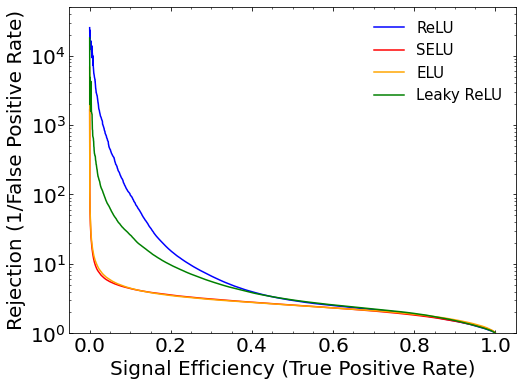

In [24]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands2:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands2[band][3:5]

    plt.plot(tpr_pts, mu, **bands2[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

## Models for AUC

In [25]:
#initial data

SR_low = 3.3
SR_high = 3.7
SB_low = 3.1
SB_high = 3.9
SB_width = 0.3
test_size = 0.5
EPOCHS=20
batch_size = 200

#mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

## 2 layers

In [26]:
from tensorflow.keras.callbacks import Callback

class AUCRecordsL2(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_2lay, aucsSB_foravg_2lay, aucs_foravg_2lay, aucsSB_foravg_2lay, aucs_2lay, aucs_std_2lay, aucsSB_2lay, aucsSB_std_2lay, num_epochs
        preds_hold_2lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_2lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_2lay = roc_auc_score(Y_test, preds_hold_2lay)
        print(myauc_scan_2lay)
        myaucSB_scan_2lay = roc_auc_score(Y_testSB, preds_holdSB_2lay)
        print(myaucSB_scan_2lay)
        
        aucs_foravg_2lay += [myauc_scan_2lay]
        print(aucs_foravg_2lay)
        aucsSB_foravg_2lay += [myaucSB_scan_2lay]
        print(aucsSB_foravg_2lay)
        
        aucs_2lay+=[np.mean(aucs_foravg_2lay)]
        print(aucs_2lay)
        aucs_std_2lay += [np.std(aucs_foravg_2lay)]
        print(aucs_std_2lay)
        aucsSB_2lay+=[np.mean(aucsSB_foravg_2lay)]
        print(aucsSB_2lay)
        aucsSB_std_2lay += [np.std(aucsSB_foravg_2lay)]
        print(aucsSB_std_2lay)
        
        print(f"epoch {epoch}")

In [27]:
    lambdas_2lay = []
    num_epochs = []
    aucs_2lay = []
    aucs_std_2lay = []
    aucsSB_2lay = []
    aucsSB_std_2lay = []
    aucs_foravg_2lay =[]
    aucsSB_foravg_2lay = []

    for k in range(1):
        model_cwola_scan_2lay = Sequential()
        model_cwola_scan_2lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_2lay.add(Dense(100, activation='relu'))
        model_cwola_scan_2lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_2lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_2lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_2lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_2lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_2lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_2lay = X_kcwola_train_2lay[sb_crit]
        Y_kcwola_train_2lay = Y_kcwola_train_2lay[sb_crit]
        W_kcwola_train_2lay = W_kcwola_train_2lay[sb_crit]


        X_kcwola_train_2lay, Y_kcwola_train_2lay, W_kcwola_train_2lay = shuffle(X_kcwola_train_2lay, Y_kcwola_train_2lay, 
                                                                       W_kcwola_train_2lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_2lay.fit(norm_func(X_kcwola_train_2lay)[:,1:],Y_kcwola_train_2lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_2lay, verbose=2, callbacks=[AUCRecordsL2()])

        pass
        

    
    

epoch 0
Epoch 1/20
50/50 [==============================] - 0s 5ms/step
0.8935283382871185
0.4408723014869274
[0.8935283382871185]
[0.4408723014869274]
[0.8935283382871185]
[0.0]
[0.4408723014869274]
[0.0]
epoch 0
1626/1626 - 6s - loss: 0.6544 - accuracy: 0.5106 - auc: 0.5154 - val_loss: 0.6698 - val_accuracy: 0.7866 - val_auc: 0.8906 - 6s/epoch - 4ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 0s 4ms/step
0.8995381050647369
0.4634496612083777
[0.8935283382871185, 0.8995381050647369]
[0.4408723014869274, 0.4634496612083777]
[0.8935283382871185, 0.8965332216759276]
[0.0, 0.0030048833888091653]
[0.4408723014869274, 0.4521609813476526]
[0.0, 0.011288679860725154]
epoch 1
1626/1626 - 5s - loss: 0.6542 - accuracy: 0.5132 - auc: 0.5185 - val_loss: 0.6612 - val_accuracy: 0.8064 - val_auc: 0.8977 - 5s/epoch - 3ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 0s 4ms/step
0.8641875994230774
0.41116331079500357
[0.8935283382871185, 0.8995381050647369, 0.864

50/50 [==============================] - 0s 4ms/step
0.9078560581899267
0.30872711597840974
[0.8935283382871185, 0.8995381050647369, 0.8641875994230774, 0.8214416891794203, 0.9025840596995711, 0.8982783077671697, 0.9088398174121944, 0.897918437488352, 0.9035392253659551, 0.9078560581899267]
[0.4408723014869274, 0.4634496612083777, 0.41116331079500357, 0.3081411356131546, 0.3955665753993475, 0.3232536591178011, 0.36491341811848044, 0.33171607499771494, 0.3627031304160774, 0.30872711597840974]
[0.8935283382871185, 0.8965332216759276, 0.8857513475916443, 0.8696739329885883, 0.8762559583307847, 0.8799263499035156, 0.8840568452618982, 0.8857895442902051, 0.8877617310763996, 0.8897711637877522]
[0.0, 0.0030048833888091653, 0.015444001003374926, 0.030892355950944545, 0.030606573728223136, 0.029120339414863142, 0.028796147227058665, 0.027323644608488795, 0.026358000955522806, 0.025721783984150398]
[0.4408723014869274, 0.4521609813476526, 0.43849509116343627, 0.40590660227586584, 0.403838596900

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 4ms/step
0.9110003715559618
0.32434028932598474
[0.8935283382871185, 0.8995381050647369, 0.8641875994230774, 0.8214416891794203, 0.9025840596995711, 0.8982783077671697, 0.9088398174121944, 0.897918437488352, 0.9035392253659551, 0.9078560581899267, 0.924749847017838, 0.9093806835721656, 0.9121419340801559, 0.9158047542925905, 0.9110003715559618]
[0.4408723014869274, 0.4634496612083777, 0.41116331079500357, 0.3081411356131546, 0.3955665753993475, 0.3232536591178011, 0.36491341811848044, 0.33171607499771494, 0.3627031304160774, 0.30872711597840974, 0.38114006167866704, 0.38401261353722127, 0.35621348460560054, 0.3888337195192314, 0.32434028932598474]
[0.8935283382871185, 0.8965332216759276, 0.8857513475916443, 0.8696739329885883, 0.8762559583307847, 0.8799263499035156, 0.8840568452618982, 0.8857895442902051, 0.8877617310763996, 0.8897711637877522, 0.8929510440813964, 0.8943201807056272, 0.8956910848113602, 0.8971277754885909

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 5ms/step
0.9017589326084914
0.36485649427694944
[0.8935283382871185, 0.8995381050647369, 0.8641875994230774, 0.8214416891794203, 0.9025840596995711, 0.8982783077671697, 0.9088398174121944, 0.897918437488352, 0.9035392253659551, 0.9078560581899267, 0.924749847017838, 0.9093806835721656, 0.9121419340801559, 0.9158047542925905, 0.9110003715559618, 0.900977877983806, 0.9137213863017796, 0.9079792062693739, 0.9017589326084914]
[0.4408723014869274, 0.4634496612083777, 0.41116331079500357, 0.3081411356131546, 0.3955665753993475, 0.3232536591178011, 0.36491341811848044, 0.33171607499771494, 0.3627031304160774, 0.30872711597840974, 0.38114006167866704, 0.38401261353722127, 0.35621348460560054, 0.3888337195192314, 0.32434028932598474, 0.31101069924257063, 0.3868965592538235, 0.35022617778066367, 0.36485649427694944]
[0.8935283382871185, 0.8965332216759276, 0.8857513475916443, 0.8696739329885883, 0.8762559583307847, 0.87992634990351

In [28]:
aucs_2lay = np.asarray(aucs_2lay)
aucs_std_2lay = np.asarray(aucs_std_2lay)

aucsSB_2lay = np.asarray(aucsSB_2lay)
aucsSB_std_2lay = np.asarray(aucsSB_std_2lay)

print(aucs_2lay)
print(aucsSB_2lay)

[0.89352834 0.89653322 0.88575135 0.86967393 0.87625596 0.87992635
 0.88405685 0.88578954 0.88776173 0.88977116 0.89295104 0.89432018
 0.89569108 0.89712778 0.89805262 0.89823544 0.89914638 0.89963709
 0.89974877 0.89937356]
[0.4408723  0.45216098 0.43849509 0.4059066  0.4038386  0.39040777
 0.38676572 0.37988452 0.37797547 0.37105064 0.37196786 0.37297159
 0.3716825  0.37290759 0.36966977 0.36600358 0.36723258 0.36628778
 0.36621245 0.36368681]


(0.0, 1.0)

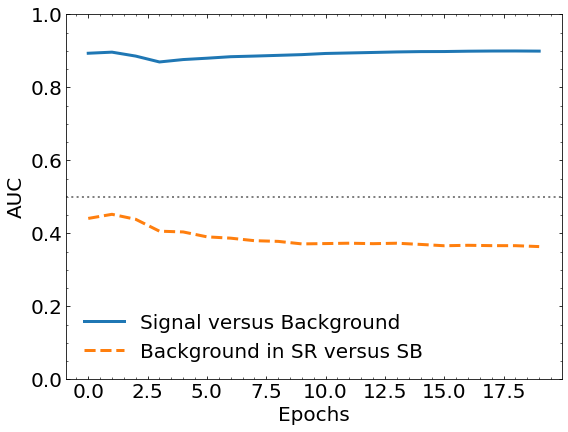

In [29]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

## 3 layers

In [30]:
class AUCRecordsL3(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_3lay, aucsSB_foravg_3lay, aucs_foravg_3lay, aucsSB_foravg_3lay, aucs_3lay, aucs_std_3lay, aucsSB_3lay, aucsSB_std_3lay, num_epochs
        preds_hold_3lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_3lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_3lay = roc_auc_score(Y_test, preds_hold_3lay)
        print(myauc_scan_3lay)
        myaucSB_scan_3lay = roc_auc_score(Y_testSB, preds_holdSB_3lay)
        print(myaucSB_scan_3lay)
        
        aucs_foravg_3lay += [myauc_scan_3lay]
        print(aucs_foravg_3lay)
        aucsSB_foravg_3lay += [myaucSB_scan_3lay]
        print(aucsSB_foravg_3lay)
        
        aucs_3lay+=[np.mean(aucs_foravg_3lay)]
        print(aucs_3lay)
        aucs_std_3lay += [np.std(aucs_foravg_3lay)]
        print(aucs_std_3lay)
        aucsSB_3lay+=[np.mean(aucsSB_foravg_3lay)]
        print(aucsSB_3lay)
        aucsSB_std_3lay += [np.std(aucsSB_foravg_3lay)]
        print(aucsSB_std_3lay)
        
        print(f"epoch {epoch}")

In [31]:
    lambdas_3lay = []
    num_epochs = []
    aucs_3lay = []
    aucs_std_3lay = []
    aucsSB_3lay = []
    aucsSB_std_3lay = []
    aucs_foravg_3lay =[]
    aucsSB_foravg_3lay = []

    for k in range(1):
        model_cwola_scan_3lay = Sequential()
        model_cwola_scan_3lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_3lay.add(Dense(100, activation='relu'))
        model_cwola_scan_3lay.add(Dense(64, activation='relu'))
        model_cwola_scan_3lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_3lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_3lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_3lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_3lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_3lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_3lay = X_kcwola_train_3lay[sb_crit]
        Y_kcwola_train_3lay = Y_kcwola_train_3lay[sb_crit]
        W_kcwola_train_3lay = W_kcwola_train_3lay[sb_crit]


        X_kcwola_train_3lay, Y_kcwola_train_3lay, W_kcwola_train_3lay = shuffle(X_kcwola_train_3lay, Y_kcwola_train_3lay, 
                                                                       W_kcwola_train_3lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_3lay.fit(norm_func(X_kcwola_train_3lay)[:,1:],Y_kcwola_train_3lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_3lay, verbose=2, callbacks=[AUCRecordsL3()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 0s 5ms/step
0.8895259100261141
0.4382468941718877
[0.8895259100261141]
[0.4382468941718877]
[0.8895259100261141]
[0.0]
[0.4382468941718877]
[0.0]
epoch 0
1626/1626 - 7s - loss: 0.6544 - accuracy: 0.5110 - auc: 0.5147 - val_loss: 0.6574 - val_accuracy: 0.8037 - val_auc: 0.8881 - 7s/epoch - 4ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 0s 5ms/step
0.8931879945735558
0.4116539330359631
[0.8895259100261141, 0.8931879945735558]
[0.4382468941718877, 0.4116539330359631]
[0.8895259100261141, 0.891356952299835]
[0.0, 0.0018310422737208287]
[0.4382468941718877, 0.4249504136039254]
[0.0, 0.013296480567962315]
epoch 1
1626/1626 - 5s - loss: 0.6542 - accuracy: 0.5124 - auc: 0.5173 - val_loss: 0.6436 - val_accuracy: 0.6857 - val_auc: 0.8921 - 5s/epoch - 3ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 0s 6ms/step
0.8500611802210507
0.2777020267248592
[0.8895259100261141, 0.8931879945735558, 0.85006

50/50 [==============================] - 0s 5ms/step
0.9236647645551581
0.3892328616505828
[0.8895259100261141, 0.8931879945735558, 0.8500611802210507, 0.8957402955943068, 0.9098654709424367, 0.8885185365453937, 0.9167710432181048, 0.9152856702713646, 0.9160205746446446, 0.9236647645551581]
[0.4382468941718877, 0.4116539330359631, 0.2777020267248592, 0.4010077923574296, 0.3870453426444693, 0.37150672333582946, 0.38083767427684856, 0.332348043735037, 0.355432016590134, 0.3892328616505828]
[0.8895259100261141, 0.891356952299835, 0.8775916949402403, 0.8821288451037569, 0.8876761702714928, 0.8878165646504762, 0.891952918731566, 0.8948695126740409, 0.8972196306707746, 0.8998641440592129]
[0.0, 0.0018310422737208287, 0.019524337740980023, 0.01864556295708955, 0.02003039890905371, 0.018287863551768445, 0.01973130787520477, 0.02000511405203226, 0.01999804611838011, 0.020563820735754308]
[0.4382468941718877, 0.4249504136039254, 0.37586761797756996, 0.38215266157253486, 0.38313119778692173, 0.38

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 6ms/step
0.8984505265760255
0.38158890796570366
[0.8895259100261141, 0.8931879945735558, 0.8500611802210507, 0.8957402955943068, 0.9098654709424367, 0.8885185365453937, 0.9167710432181048, 0.9152856702713646, 0.9160205746446446, 0.9236647645551581, 0.907552947687249, 0.9007072319014657, 0.9213051463185167, 0.9157652587427144, 0.8984505265760255]
[0.4382468941718877, 0.4116539330359631, 0.2777020267248592, 0.4010077923574296, 0.3870453426444693, 0.37150672333582946, 0.38083767427684856, 0.332348043735037, 0.355432016590134, 0.3892328616505828, 0.3262755708321925, 0.32397604865156043, 0.3530169551829063, 0.34861433019851373, 0.38158890796570366]
[0.8895259100261141, 0.891356952299835, 0.8775916949402403, 0.8821288451037569, 0.8876761702714928, 0.8878165646504762, 0.891952918731566, 0.8948695126740409, 0.8972196306707746, 0.8998641440592129, 0.9005631262072161, 0.9005751350150702, 0.9021697512691815, 0.9031408589458625, 0.90

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 6ms/step
0.9138737400485377
0.38640270917918484
[0.8895259100261141, 0.8931879945735558, 0.8500611802210507, 0.8957402955943068, 0.9098654709424367, 0.8885185365453937, 0.9167710432181048, 0.9152856702713646, 0.9160205746446446, 0.9236647645551581, 0.907552947687249, 0.9007072319014657, 0.9213051463185167, 0.9157652587427144, 0.8984505265760255, 0.9029948118655444, 0.9057517174804095, 0.8938571675625323, 0.9138737400485377]
[0.4382468941718877, 0.4116539330359631, 0.2777020267248592, 0.4010077923574296, 0.3870453426444693, 0.37150672333582946, 0.38083767427684856, 0.332348043735037, 0.355432016590134, 0.3892328616505828, 0.3262755708321925, 0.32397604865156043, 0.3530169551829063, 0.34861433019851373, 0.38158890796570366, 0.35305442157511885, 0.35131330514857456, 0.34389159690505366, 0.38640270917918484]
[0.8895259100261141, 0.891356952299835, 0.8775916949402403, 0.8821288451037569, 0.8876761702714928, 0.8878165646504762,

In [32]:
aucs_3lay = np.asarray(aucs_3lay)
aucs_std_3lay = np.asarray(aucs_std_3lay)

aucsSB_3lay = np.asarray(aucsSB_3lay)
aucsSB_std_3lay = np.asarray(aucsSB_std_3lay)

print(aucs_3lay)
print(aucsSB_3lay)

[0.88952591 0.89135695 0.87759169 0.88212885 0.88767617 0.88781656
 0.89195292 0.89486951 0.89721963 0.89986414 0.90056313 0.90057514
 0.90216975 0.90314086 0.90282817 0.90283859 0.90300995 0.90250146
 0.9031     0.90290107]
[0.43824689 0.42495041 0.37586762 0.38215266 0.3831312  0.38119379
 0.38114291 0.37504355 0.37286449 0.37450133 0.37011717 0.36627208
 0.36525245 0.36406402 0.36523234 0.36447122 0.36369723 0.36259691
 0.36384985 0.36256718]


(0.0, 1.0)

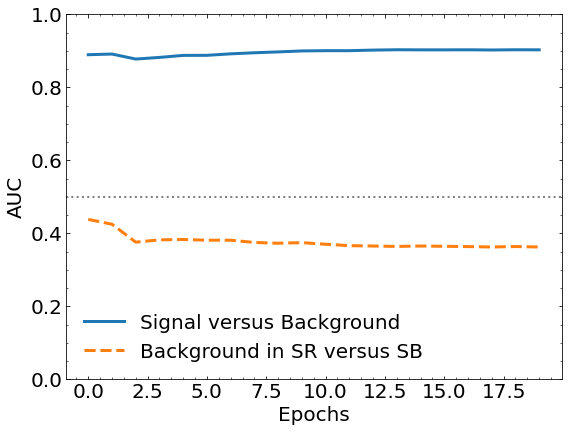

In [33]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

## 4 layers

In [34]:
class AUCRecordsL4(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_4lay, aucsSB_foravg_4lay, aucs_foravg_4lay, aucsSB_foravg_4lay, aucs_4lay, aucs_std_4lay, aucsSB_4lay, aucsSB_std_4lay, num_epochs
        preds_hold_4lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_4lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_4lay = roc_auc_score(Y_test, preds_hold_4lay)
        print(myauc_scan_4lay)
        myaucSB_scan_4lay = roc_auc_score(Y_testSB, preds_holdSB_4lay)
        print(myaucSB_scan_4lay)
        
        aucs_foravg_4lay += [myauc_scan_4lay]
        print(aucs_foravg_4lay)
        aucsSB_foravg_4lay += [myaucSB_scan_4lay]
        print(aucsSB_foravg_4lay)
        
        aucs_4lay+=[np.mean(aucs_foravg_4lay)]
        print(aucs_4lay)
        aucs_std_4lay += [np.std(aucs_foravg_4lay)]
        print(aucs_std_4lay)
        aucsSB_4lay+=[np.mean(aucsSB_foravg_4lay)]
        print(aucsSB_4lay)
        aucsSB_std_4lay += [np.std(aucsSB_foravg_4lay)]
        print(aucsSB_std_4lay)
        
        print(f"epoch {epoch}")

In [35]:
    lambdas_4lay = []
    num_epochs = []
    aucs_4lay = []
    aucs_std_4lay = []
    aucsSB_4lay = []
    aucsSB_std_4lay = []
    aucs_foravg_4lay =[]
    aucsSB_foravg_4lay = []

    for k in range(1):
        model_cwola_scan_4lay = Sequential()
        model_cwola_scan_4lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_4lay.add(Dense(100, activation='relu'))
        model_cwola_scan_4lay.add(Dense(64, activation='relu'))
        model_cwola_scan_4lay.add(Dense(100, activation='relu'))
        model_cwola_scan_4lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_4lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_4lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_4lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_4lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_4lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_4lay = X_kcwola_train_4lay[sb_crit]
        Y_kcwola_train_4lay = Y_kcwola_train_4lay[sb_crit]
        W_kcwola_train_4lay = W_kcwola_train_4lay[sb_crit]


        X_kcwola_train_4lay, Y_kcwola_train_4lay, W_kcwola_train_4lay = shuffle(X_kcwola_train_4lay, Y_kcwola_train_4lay, 
                                                                       W_kcwola_train_4lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_4lay.fit(norm_func(X_kcwola_train_4lay)[:,1:],Y_kcwola_train_4lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_4lay, verbose=2, callbacks=[AUCRecordsL4()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 0s 8ms/step
0.8912915269712454
0.45839461969441764
[0.8912915269712454]
[0.45839461969441764]
[0.8912915269712454]
[0.0]
[0.45839461969441764]
[0.0]
epoch 0
1626/1626 - 8s - loss: 0.6544 - accuracy: 0.5089 - auc: 0.5132 - val_loss: 0.6711 - val_accuracy: 0.7820 - val_auc: 0.8867 - 8s/epoch - 5ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 0s 7ms/step
0.8634632450159461
0.4279669050393143
[0.8912915269712454, 0.8634632450159461]
[0.45839461969441764, 0.4279669050393143]
[0.8912915269712454, 0.8773773859935957]
[0.0, 0.013914140977649647]
[0.45839461969441764, 0.443180762366866]
[0.0, 0.015213857327551678]
epoch 1
1626/1626 - 6s - loss: 0.6543 - accuracy: 0.5108 - auc: 0.5171 - val_loss: 0.6714 - val_accuracy: 0.7902 - val_auc: 0.8583 - 6s/epoch - 4ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 0s 7ms/step
0.8953705422502305
0.42674894183131873
[0.8912915269712454, 0.8634632450159461, 0.

50/50 [==============================] - 0s 7ms/step
0.8849496241412244
0.32556205786449705
[0.8912915269712454, 0.8634632450159461, 0.8953705422502305, 0.885559596228402, 0.8907555477208053, 0.8897169402535531, 0.8812200069227085, 0.8926920943696794, 0.8996902629447112, 0.8849496241412244]
[0.45839461969441764, 0.4279669050393143, 0.42674894183131873, 0.41702656027747464, 0.3316470495325074, 0.3776296863025053, 0.3507499744651411, 0.3909981388956817, 0.34487523628819194, 0.32556205786449705]
[0.8912915269712454, 0.8773773859935957, 0.8833751047458073, 0.883921227616456, 0.8852880916373259, 0.8860262330733638, 0.8853396293375558, 0.8862586874665712, 0.8877510847419201, 0.8874709386818506]
[0.0, 0.013914140977649647, 0.014177945545524824, 0.01231484289337209, 0.011348900977493102, 0.010490736789922501, 0.009857072785957629, 0.00953568683057355, 0.009931971717773878, 0.009459703606199655]
[0.45839461969441764, 0.443180762366866, 0.43770348885501686, 0.4325342567106313, 0.4123568152750064

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 7ms/step
0.9139188563983807
0.3536046307305931
[0.8912915269712454, 0.8634632450159461, 0.8953705422502305, 0.885559596228402, 0.8907555477208053, 0.8897169402535531, 0.8812200069227085, 0.8926920943696794, 0.8996902629447112, 0.8849496241412244, 0.9053649544481606, 0.9008849690295929, 0.9088551980565834, 0.9106517622863004, 0.9139188563983807]
[0.45839461969441764, 0.4279669050393143, 0.42674894183131873, 0.41702656027747464, 0.3316470495325074, 0.3776296863025053, 0.3507499744651411, 0.3909981388956817, 0.34487523628819194, 0.32556205786449705, 0.3688286123628858, 0.31802001670920066, 0.36835115449134237, 0.31482092276387935, 0.3536046307305931]
[0.8912915269712454, 0.8773773859935957, 0.8833751047458073, 0.883921227616456, 0.8852880916373259, 0.8860262330733638, 0.8853396293375558, 0.8862586874665712, 0.8877510847419201, 0.8874709386818506, 0.8890976673878787, 0.8900799425246881, 0.8915241929502186, 0.8928904479027958,

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 7ms/step
0.9237694093235683
0.326749153108728
[0.8912915269712454, 0.8634632450159461, 0.8953705422502305, 0.885559596228402, 0.8907555477208053, 0.8897169402535531, 0.8812200069227085, 0.8926920943696794, 0.8996902629447112, 0.8849496241412244, 0.9053649544481606, 0.9008849690295929, 0.9088551980565834, 0.9106517622863004, 0.9139188563983807, 0.9144798491458609, 0.9022601042463271, 0.9150088579344464, 0.9237694093235683]
[0.45839461969441764, 0.4279669050393143, 0.42674894183131873, 0.41702656027747464, 0.3316470495325074, 0.3776296863025053, 0.3507499744651411, 0.3909981388956817, 0.34487523628819194, 0.32556205786449705, 0.3688286123628858, 0.31802001670920066, 0.36835115449134237, 0.31482092276387935, 0.3536046307305931, 0.3062371588134803, 0.3196598853990336, 0.35311802538266923, 0.326749153108728]
[0.8912915269712454, 0.8773773859935957, 0.8833751047458073, 0.883921227616456, 0.8852880916373259, 0.8860262330733638, 

In [36]:
aucs_4lay = np.asarray(aucs_4lay)
aucs_std_4lay = np.asarray(aucs_std_4lay)

aucsSB_4lay = np.asarray(aucsSB_4lay)
aucsSB_std_4lay = np.asarray(aucsSB_std_4lay)

print(aucs_4lay)
print(aucsSB_4lay)

[0.89129153 0.87737739 0.8833751  0.88392123 0.88528809 0.88602623
 0.88533963 0.88625869 0.88775108 0.88747094 0.88909767 0.89007994
 0.89152419 0.89289045 0.89429234 0.89555406 0.89594853 0.89700744
 0.89841597 0.89930544]
[0.45839462 0.44318076 0.43770349 0.43253426 0.41235682 0.40656896
 0.39859482 0.39764523 0.3917819  0.38515992 0.38367525 0.37820398
 0.37744607 0.37297285 0.37168163 0.36759135 0.36477186 0.36412442
 0.3621573  0.36156297]


(0.0, 1.0)

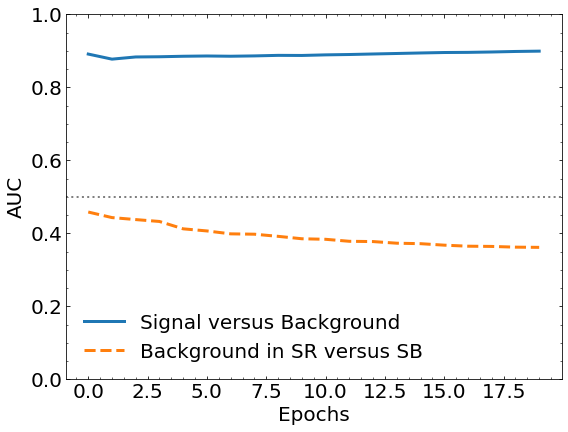

In [37]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

## 5 layers

In [38]:
class AUCRecordsL5(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_5lay, aucsSB_foravg_5lay, aucs_foravg_5lay, aucsSB_foravg_5lay, aucs_5lay, aucs_std_5lay, aucsSB_5lay, aucsSB_std_5lay, num_epochs
        preds_hold_5lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_5lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_5lay = roc_auc_score(Y_test, preds_hold_5lay)
        print(myauc_scan_5lay)
        myaucSB_scan_5lay = roc_auc_score(Y_testSB, preds_holdSB_5lay)
        print(myaucSB_scan_5lay)
        
        aucs_foravg_5lay += [myauc_scan_5lay]
        print(aucs_foravg_5lay)
        aucsSB_foravg_5lay += [myaucSB_scan_5lay]
        print(aucsSB_foravg_5lay)
        
        aucs_5lay+=[np.mean(aucs_foravg_5lay)]
        print(aucs_5lay)
        aucs_std_5lay += [np.std(aucs_foravg_5lay)]
        print(aucs_std_5lay)
        aucsSB_5lay+=[np.mean(aucsSB_foravg_5lay)]
        print(aucsSB_5lay)
        aucsSB_std_5lay += [np.std(aucsSB_foravg_5lay)]
        print(aucsSB_std_5lay)
        
        print(f"epoch {epoch}")

In [39]:
    lambdas_5lay = []
    num_epochs = []
    aucs_5lay = []
    aucs_std_5lay = []
    aucsSB_5lay = []
    aucsSB_std_5lay = []
    aucs_foravg_5lay =[]
    aucsSB_foravg_5lay = []

    for k in range(1):
        model_cwola_scan_5lay = Sequential()
        model_cwola_scan_5lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_5lay.add(Dense(100, activation='relu'))
        model_cwola_scan_5lay.add(Dense(64, activation='relu'))
        model_cwola_scan_5lay.add(Dense(100, activation='relu'))
        model_cwola_scan_5lay.add(Dense(64, activation='relu'))
        model_cwola_scan_5lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_5lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_5lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_5lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_5lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_5lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_5lay = X_kcwola_train_5lay[sb_crit]
        Y_kcwola_train_5lay = Y_kcwola_train_5lay[sb_crit]
        W_kcwola_train_5lay = W_kcwola_train_5lay[sb_crit]


        X_kcwola_train_5lay, Y_kcwola_train_5lay, W_kcwola_train_5lay = shuffle(X_kcwola_train_5lay, Y_kcwola_train_5lay, 
                                                                       W_kcwola_train_5lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_5lay.fit(norm_func(X_kcwola_train_5lay)[:,1:],Y_kcwola_train_5lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_5lay, verbose=2, callbacks=[AUCRecordsL5()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 1s 10ms/step
0.8846113636472549
0.4859508201208085
[0.8846113636472549]
[0.4859508201208085]
[0.8846113636472549]
[0.0]
[0.4859508201208085]
[0.0]
epoch 0
1626/1626 - 9s - loss: 0.6544 - accuracy: 0.5092 - auc: 0.5134 - val_loss: 0.6809 - val_accuracy: 0.7913 - val_auc: 0.8730 - 9s/epoch - 5ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 1s 9ms/step
0.8958338562547612
0.40758854240187725
[0.8846113636472549, 0.8958338562547612]
[0.4859508201208085, 0.40758854240187725]
[0.8846113636472549, 0.890222609951008]
[0.0, 0.005611246303753148]
[0.4859508201208085, 0.44676968126134287]
[0.0, 0.039181138859465614]
epoch 1
1626/1626 - 7s - loss: 0.6543 - accuracy: 0.5110 - auc: 0.5169 - val_loss: 0.6702 - val_accuracy: 0.6487 - val_auc: 0.8927 - 7s/epoch - 4ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 1s 10ms/step
0.8727070275993227
0.41232561664797207
[0.8846113636472549, 0.8958338562547612, 0.

50/50 [==============================] - 1s 9ms/step
0.9030548969406168
0.3057459508225127
[0.8846113636472549, 0.8958338562547612, 0.8727070275993227, 0.8879231238152128, 0.8872137590952716, 0.8987271512534882, 0.9065358562860273, 0.8986237642027053, 0.9045323986157525, 0.9030548969406168]
[0.4859508201208085, 0.40758854240187725, 0.41232561664797207, 0.3692397438935542, 0.3378021579036598, 0.3666298772982738, 0.38264040778526925, 0.344927588060924, 0.32656382552386976, 0.3057459508225127]
[0.8846113636472549, 0.890222609951008, 0.8843840825004463, 0.885268842829138, 0.8856578260823647, 0.8878360469442185, 0.8905074482787627, 0.8915219877692555, 0.8929675889744217, 0.8939763197710413]
[0.0, 0.005611246303753148, 0.009442855975260643, 0.008320099112679865, 0.007482277145429486, 0.008389097489157707, 0.01015585625484923, 0.009871867699675747, 0.010165809252557499, 0.010107776727049461]
[0.4859508201208085, 0.44676968126134287, 0.43528832639021925, 0.418776180766053, 0.4025813761935743, 

epoch 14
Epoch 15/20
50/50 [==============================] - 0s 8ms/step
0.9189834694521121
0.3591251255234431
[0.8846113636472549, 0.8958338562547612, 0.8727070275993227, 0.8879231238152128, 0.8872137590952716, 0.8987271512534882, 0.9065358562860273, 0.8986237642027053, 0.9045323986157525, 0.9030548969406168, 0.9138388179769747, 0.9113735377068373, 0.9122883198791367, 0.9110594799589511, 0.9189834694521121]
[0.4859508201208085, 0.40758854240187725, 0.41232561664797207, 0.3692397438935542, 0.3378021579036598, 0.3666298772982738, 0.38264040778526925, 0.344927588060924, 0.32656382552386976, 0.3057459508225127, 0.33568702931160393, 0.35822962343456544, 0.3247759272392015, 0.3464016553791317, 0.3591251255234431]
[0.8846113636472549, 0.890222609951008, 0.8843840825004463, 0.885268842829138, 0.8856578260823647, 0.8878360469442185, 0.8905074482787627, 0.8915219877692555, 0.8929675889744217, 0.8939763197710413, 0.8957820014261262, 0.8970812961161854, 0.8982510671748739, 0.899165953802308, 0.9

epoch 18
Epoch 19/20
50/50 [==============================] - 0s 8ms/step
0.8887496968379243
0.31490478709173714
[0.8846113636472549, 0.8958338562547612, 0.8727070275993227, 0.8879231238152128, 0.8872137590952716, 0.8987271512534882, 0.9065358562860273, 0.8986237642027053, 0.9045323986157525, 0.9030548969406168, 0.9138388179769747, 0.9113735377068373, 0.9122883198791367, 0.9110594799589511, 0.9189834694521121, 0.8792386062257719, 0.9131158130099112, 0.9035877523044002, 0.8887496968379243]
[0.4859508201208085, 0.40758854240187725, 0.41232561664797207, 0.3692397438935542, 0.3378021579036598, 0.3666298772982738, 0.38264040778526925, 0.344927588060924, 0.32656382552386976, 0.3057459508225127, 0.33568702931160393, 0.35822962343456544, 0.3247759272392015, 0.3464016553791317, 0.3591251255234431, 0.3691048614115061, 0.3643076431806554, 0.33053420245346415, 0.31490478709173714]
[0.8846113636472549, 0.890222609951008, 0.8843840825004463, 0.885268842829138, 0.8856578260823647, 0.8878360469442185,

In [40]:
aucs_5lay = np.asarray(aucs_5lay)
aucs_std_5lay = np.asarray(aucs_std_5lay)

aucsSB_5lay = np.asarray(aucsSB_5lay)
aucsSB_std_5lay = np.asarray(aucsSB_std_5lay)

print(aucs_5lay)
print(aucsSB_5lay)

[0.88461136 0.89022261 0.88438408 0.88526884 0.88565783 0.88783605
 0.89050745 0.89152199 0.89296759 0.89397632 0.895782   0.8970813
 0.89825107 0.89916595 0.90048712 0.89915909 0.89998007 0.9001805
 0.89957888 0.89968315]
[0.48595082 0.44676968 0.43528833 0.41877618 0.40258138 0.39658946
 0.39459674 0.38838809 0.38151873 0.37394145 0.37046378 0.36944427
 0.36600824 0.36460777 0.36424226 0.36454617 0.36453214 0.36264337
 0.36013081 0.35816689]


(0.0, 1.0)

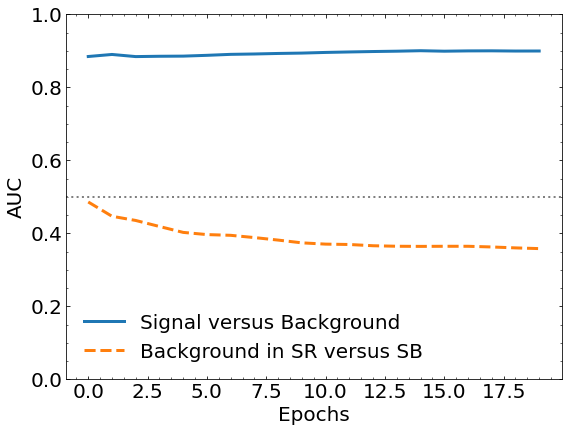

In [41]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background",linewidth=3)
#plt.fill_between(epochs,aucs+aucs_std, aucs-aucs_std, alpha=0.2)
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB",ls="--",linewidth=3)
#plt.fill_between(epochs,aucsSB+aucsSB_std, aucsSB-aucsSB_std,alpha=0.2)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])

# AUC all architectures

C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\2768153683.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

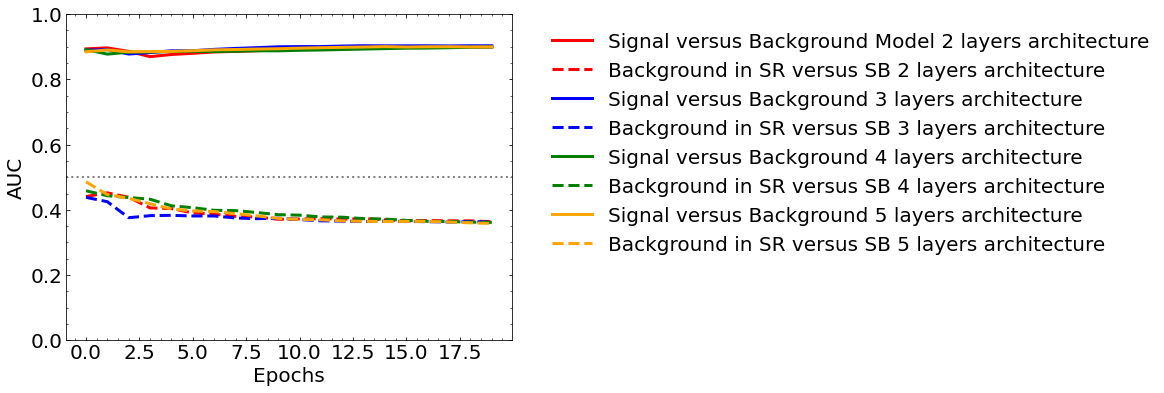

In [42]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [43]:
class AUCRecordsL15(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_15lay, aucsSB_foravg_15lay, aucs_foravg_15lay, aucsSB_foravg_15lay, aucs_15lay, aucs_std_15lay, aucsSB_15lay, aucsSB_std_15lay, num_epochs
        preds_hold_15lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_15lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_15lay = roc_auc_score(Y_test, preds_hold_15lay)
        print(myauc_scan_15lay)
        myaucSB_scan_15lay = roc_auc_score(Y_testSB, preds_holdSB_15lay)
        print(myaucSB_scan_15lay)
        
        aucs_foravg_15lay += [myauc_scan_15lay]
        print(aucs_foravg_15lay)
        aucsSB_foravg_15lay += [myaucSB_scan_15lay]
        print(aucsSB_foravg_15lay)
        
        aucs_15lay+=[np.mean(aucs_foravg_15lay)]
        print(aucs_15lay)
        aucs_std_15lay += [np.std(aucs_foravg_15lay)]
        print(aucs_std_15lay)
        aucsSB_15lay+=[np.mean(aucsSB_foravg_15lay)]
        print(aucsSB_15lay)
        aucsSB_std_15lay += [np.std(aucsSB_foravg_15lay)]
        print(aucsSB_std_15lay)
        
        print(f"epoch {epoch}")

In [44]:
    lambdas_15lay = []
    num_epochs = []
    aucs_15lay = []
    aucs_std_15lay = []
    aucsSB_15lay = []
    aucsSB_std_15lay = []
    aucs_foravg_15lay =[]
    aucsSB_foravg_15lay = []

    for k in range(1):
        model_cwola_scan_15lay = Sequential()
        model_cwola_scan_15lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(100, activation='relu'))
        model_cwola_scan_15lay.add(Dense(64, activation='relu'))
        model_cwola_scan_15lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_15lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_15lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_15lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_15lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_15lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_15lay = X_kcwola_train_15lay[sb_crit]
        Y_kcwola_train_15lay = Y_kcwola_train_15lay[sb_crit]
        W_kcwola_train_15lay = W_kcwola_train_15lay[sb_crit]


        X_kcwola_train_15lay, Y_kcwola_train_15lay, W_kcwola_train_15lay = shuffle(X_kcwola_train_15lay, Y_kcwola_train_15lay, 
                                                                       W_kcwola_train_15lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_15lay.fit(norm_func(X_kcwola_train_15lay)[:,1:],Y_kcwola_train_15lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_15lay, verbose=2, callbacks=[AUCRecordsL15()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 1s 22ms/step
0.4136653174939655
0.5964642884262774
[0.4136653174939655]
[0.5964642884262774]
[0.4136653174939655]
[0.0]
[0.5964642884262774]
[0.0]
epoch 0
1626/1626 - 14s - loss: 0.6546 - accuracy: 0.4994 - auc: 0.4994 - val_loss: 0.6939 - val_accuracy: 0.4495 - val_auc: 0.5000 - 14s/epoch - 9ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 1s 23ms/step
0.5
0.5
[0.4136653174939655, 0.5]
[0.5964642884262774, 0.5]
[0.4136653174939655, 0.45683265874698276]
[0.0, 0.043167341253017244]
[0.5964642884262774, 0.5482321442131387]
[0.0, 0.048232144213138706]
epoch 1
1626/1626 - 12s - loss: 0.6546 - accuracy: 0.5002 - auc: 0.5002 - val_loss: 0.6935 - val_accuracy: 0.4495 - val_auc: 0.5000 - 12s/epoch - 7ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 1s 23ms/step
0.5
0.5
[0.4136653174939655, 0.5, 0.5]
[0.5964642884262774, 0.5, 0.5]
[0.4136653174939655, 0.45683265874698276, 0.4712217724979885]
[0.0, 

50/50 [==============================] - 1s 21ms/step
0.5
0.5
[0.4136653174939655, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500024721471422, 0.5, 0.5, 0.5, 0.5]
[0.5964642884262774, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.4136653174939655, 0.45683265874698276, 0.4712217724979885, 0.4784163293734914, 0.4827330634987931, 0.48561088624899423, 0.4876700055664839, 0.4892112548706734, 0.49041000432948745, 0.4913690038965387, 0.4921536399059443]
[0.0, 0.043167341253017244, 0.04069855963440305, 0.03738401413894491, 0.03453387300241379, 0.03217503648322584, 0.030212288595998164, 0.028553681555196136, 0.027133345335633892, 0.02590122984954439, 0.024820187862059973]
[0.5964642884262774, 0.5482321442131387, 0.5321547628087592, 0.5241160721065694, 0.5192928576852556, 0.5160773814043796, 0.5137806126323253, 0.5120580360532847, 0.5107182542695864, 0.5096464288426278, 0.5087694807660252]
[0.0, 0.048232144213138706, 0.04547370165903717, 0.04177026216757272, 0.03858571537051096, 0.03595011772038375, 0.03

epoch 16
Epoch 17/20
50/50 [==============================] - 1s 22ms/step
0.5
0.5
[0.4136653174939655, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500024721471422, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49997527852857804, 0.5, 0.5]
[0.5964642884262774, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.4136653174939655, 0.45683265874698276, 0.4712217724979885, 0.4784163293734914, 0.4827330634987931, 0.48561088624899423, 0.4876700055664839, 0.4892112548706734, 0.49041000432948745, 0.4913690038965387, 0.4921536399059443, 0.4928075032471156, 0.4933607722281067, 0.49383500278324194, 0.4942443544995977, 0.49460408234337283, 0.4949214892643509]
[0.0, 0.043167341253017244, 0.04069855963440305, 0.03738401413894491, 0.03453387300241379, 0.03217503648322584, 0.030212288595998164, 0.028553681555196136, 0.027133345335633892, 0.02590122984954439, 0.024820187862059973, 0.023862267809392265, 0.023006097058550678, 0.022235070986767157, 0.02153565539413735, 0.02089830104937729, 0.02031404

In [45]:
aucs_15lay = np.asarray(aucs_15lay)
aucs_std_15lay = np.asarray(aucs_std_15lay)

aucsSB_15lay = np.asarray(aucsSB_15lay)
aucsSB_std_15lay = np.asarray(aucsSB_std_15lay)

print(aucs_15lay)
print(aucsSB_15lay)

[0.41366532 0.45683266 0.47122177 0.47841633 0.48273306 0.48561089
 0.48767001 0.48921125 0.49041    0.491369   0.49215364 0.4928075
 0.49336077 0.493835   0.49424435 0.49460408 0.49492149 0.49520363
 0.49545607 0.49568327]
[0.59646429 0.54823214 0.53215476 0.52411607 0.51929286 0.51607738
 0.51378061 0.51205804 0.51071825 0.50964643 0.50876948 0.50803869
 0.50742033 0.50689031 0.50643095 0.50602902 0.50567437 0.50535913
 0.50507707 0.50482321]


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\4093967315.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

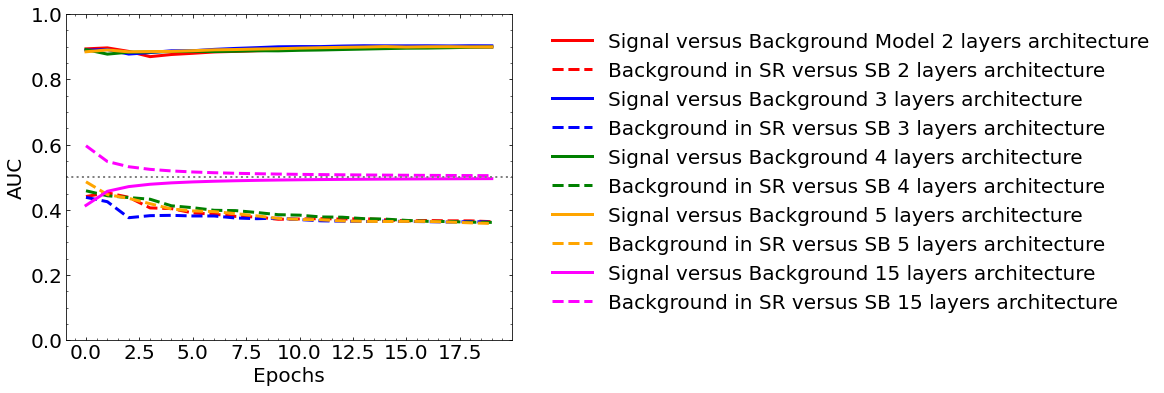

In [46]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.plot(num_epochs, aucs_15lay,label="Signal versus Background 15 layers architecture",linewidth=3,color='magenta')
plt.plot(num_epochs, aucsSB_15lay,label="Background in SR versus SB 15 layers architecture",ls="--",linewidth=3,color='magenta')

plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [47]:
class AUCRecordsL9(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_9lay, aucsSB_foravg_9lay, aucs_foravg_9lay, aucsSB_foravg_9lay, aucs_9lay, aucs_std_9lay, aucsSB_9lay, aucsSB_std_9lay, num_epochs
        preds_hold_9lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_9lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_9lay = roc_auc_score(Y_test, preds_hold_9lay)
        print(myauc_scan_9lay)
        myaucSB_scan_9lay = roc_auc_score(Y_testSB, preds_holdSB_9lay)
        print(myaucSB_scan_9lay)
        
        aucs_foravg_9lay += [myauc_scan_9lay]
        print(aucs_foravg_9lay)
        aucsSB_foravg_9lay += [myaucSB_scan_9lay]
        print(aucsSB_foravg_9lay)
        
        aucs_9lay+=[np.mean(aucs_foravg_9lay)]
        print(aucs_9lay)
        aucs_std_9lay += [np.std(aucs_foravg_9lay)]
        print(aucs_std_9lay)
        aucsSB_9lay+=[np.mean(aucsSB_foravg_9lay)]
        print(aucsSB_9lay)
        aucsSB_std_9lay += [np.std(aucsSB_foravg_9lay)]
        print(aucsSB_std_9lay)
        
        print(f"epoch {epoch}")

In [48]:
    lambdas_9lay = []
    num_epochs = []
    aucs_9lay = []
    aucs_std_9lay = []
    aucsSB_9lay = []
    aucsSB_std_9lay = []
    aucs_foravg_9lay =[]
    aucsSB_foravg_9lay = []

    for k in range(1):
        model_cwola_scan_9lay = Sequential()
        model_cwola_scan_9lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(100, activation='relu'))
        model_cwola_scan_9lay.add(Dense(64, activation='relu'))
        model_cwola_scan_9lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_9lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_9lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_9lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_9lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_9lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_9lay = X_kcwola_train_9lay[sb_crit]
        Y_kcwola_train_9lay = Y_kcwola_train_9lay[sb_crit]
        W_kcwola_train_9lay = W_kcwola_train_9lay[sb_crit]


        X_kcwola_train_9lay, Y_kcwola_train_9lay, W_kcwola_train_9lay = shuffle(X_kcwola_train_9lay, Y_kcwola_train_9lay, 
                                                                       W_kcwola_train_9lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_9lay.fit(norm_func(X_kcwola_train_9lay)[:,1:],Y_kcwola_train_9lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_9lay, verbose=2, callbacks=[AUCRecordsL9()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 1s 14ms/step
0.9001228747754105
0.5841566200754033
[0.9001228747754105]
[0.5841566200754033]
[0.9001228747754105]
[0.0]
[0.5841566200754033]
[0.0]
epoch 0
1626/1626 - 10s - loss: 0.6546 - accuracy: 0.5043 - auc: 0.5057 - val_loss: 0.6911 - val_accuracy: 0.5505 - val_auc: 0.6310 - 10s/epoch - 6ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 1s 15ms/step
0.9081974659725294
0.4952420887871636
[0.9001228747754105, 0.9081974659725294]
[0.5841566200754033, 0.4952420887871636]
[0.9001228747754105, 0.9041601703739699]
[0.0, 0.0040372955985594206]
[0.5841566200754033, 0.5396993544312834]
[0.0, 0.04445726564411984]
epoch 1
1626/1626 - 8s - loss: 0.6544 - accuracy: 0.5088 - auc: 0.5118 - val_loss: 0.6783 - val_accuracy: 0.7926 - val_auc: 0.8996 - 8s/epoch - 5ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 1s 14ms/step
0.8970683198585695
0.4470818850027265
[0.9001228747754105, 0.9081974659725294, 0.

epoch 9
Epoch 10/20
50/50 [==============================] - 1s 14ms/step
0.898543745966891
0.376325152477067
[0.9001228747754105, 0.9081974659725294, 0.8970683198585695, 0.8935335589243694, 0.879085035576209, 0.881674224323682, 0.9020699550866862, 0.9048665461290796, 0.9009386190046265, 0.898543745966891]
[0.5841566200754033, 0.4952420887871636, 0.4470818850027265, 0.43841948471398173, 0.3198364010364004, 0.27646797244194277, 0.3287435324728361, 0.3086582068829041, 0.3114043024087026, 0.376325152477067]
[0.9001228747754105, 0.9041601703739699, 0.9017962202021698, 0.8997305548827197, 0.8956014510214174, 0.8932802465717948, 0.8945359192167793, 0.8958272475808169, 0.896395177739018, 0.8966100345618052]
[0.0, 0.0040372955985594206, 0.004694999964104308, 0.0054160121983929605, 0.009574160291962638, 0.010164992452771434, 0.009900825424656102, 0.009871461577937777, 0.00944451190038369, 0.00898300593462592]
[0.5841566200754033, 0.5396993544312834, 0.5088268646217644, 0.49122501964481874, 0.45

epoch 14
Epoch 15/20
50/50 [==============================] - 1s 14ms/step
0.8998922281063659
0.33011967112305834
[0.9001228747754105, 0.9081974659725294, 0.8970683198585695, 0.8935335589243694, 0.879085035576209, 0.881674224323682, 0.9020699550866862, 0.9048665461290796, 0.9009386190046265, 0.898543745966891, 0.9068005524988945, 0.9134457480564663, 0.9064392173228619, 0.8991403643979824, 0.8998922281063659]
[0.5841566200754033, 0.4952420887871636, 0.4470818850027265, 0.43841948471398173, 0.3198364010364004, 0.27646797244194277, 0.3287435324728361, 0.3086582068829041, 0.3114043024087026, 0.376325152477067, 0.3766386131950515, 0.3692297497544395, 0.308905218719191, 0.30948997467035394, 0.33011967112305834]
[0.9001228747754105, 0.9041601703739699, 0.9017962202021698, 0.8997305548827197, 0.8956014510214174, 0.8932802465717948, 0.8945359192167793, 0.8958272475808169, 0.896395177739018, 0.8966100345618052, 0.8975364452833589, 0.8988622205144511, 0.8994450664227904, 0.899423301992447, 0.8994

epoch 18
Epoch 19/20
50/50 [==============================] - 1s 14ms/step
0.9186002562003193
0.31258475038072314
[0.9001228747754105, 0.9081974659725294, 0.8970683198585695, 0.8935335589243694, 0.879085035576209, 0.881674224323682, 0.9020699550866862, 0.9048665461290796, 0.9009386190046265, 0.898543745966891, 0.9068005524988945, 0.9134457480564663, 0.9064392173228619, 0.8991403643979824, 0.8998922281063659, 0.9031157995321468, 0.911331267747222, 0.9091728322032882, 0.9186002562003193]
[0.5841566200754033, 0.4952420887871636, 0.4470818850027265, 0.43841948471398173, 0.3198364010364004, 0.27646797244194277, 0.3287435324728361, 0.3086582068829041, 0.3114043024087026, 0.376325152477067, 0.3766386131950515, 0.3692297497544395, 0.308905218719191, 0.30948997467035394, 0.33011967112305834, 0.3599726027141998, 0.3528439951801389, 0.34621901050605114, 0.31258475038072314]
[0.9001228747754105, 0.9041601703739699, 0.9017962202021698, 0.8997305548827197, 0.8956014510214174, 0.8932802465717948, 0.8

In [49]:
aucs_9lay = np.asarray(aucs_9lay)
aucs_std_9lay = np.asarray(aucs_std_9lay)

aucsSB_9lay = np.asarray(aucsSB_9lay)
aucsSB_std_9lay = np.asarray(aucsSB_std_9lay)

print(aucs_9lay)
print(aucsSB_9lay)

[0.90012287 0.90416017 0.90179622 0.89973055 0.89560145 0.89328025
 0.89453592 0.89582725 0.89639518 0.89661003 0.89753645 0.89886222
 0.89944507 0.8994233  0.89945456 0.89968339 0.90036856 0.90085769
 0.90179151 0.90276994]
[0.58415662 0.53969935 0.50882686 0.49122502 0.4569473  0.42686741
 0.41284971 0.39982577 0.39000117 0.38863356 0.38754311 0.386017
 0.38008533 0.3750428  0.37204792 0.37129322 0.37020797 0.36887525
 0.36591259 0.36469626]


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\656470828.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

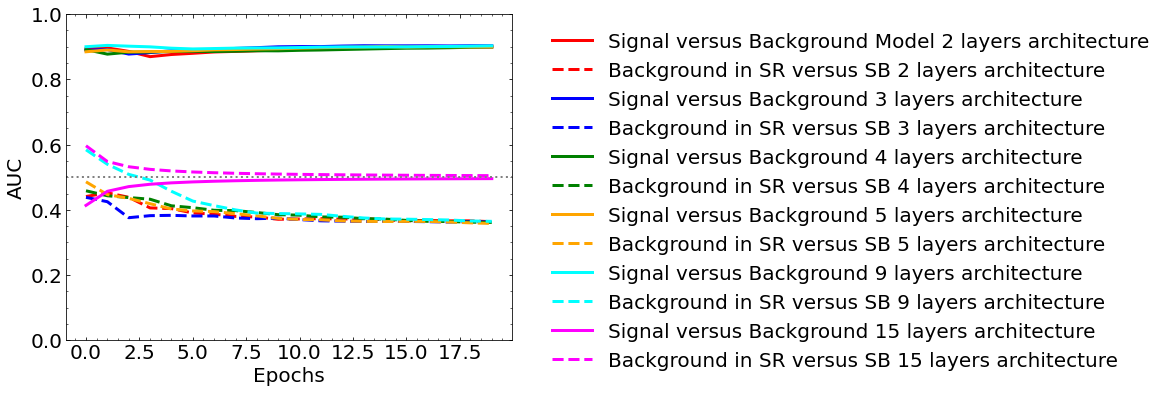

In [50]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.plot(num_epochs, aucs_9lay,label="Signal versus Background 9 layers architecture",linewidth=3,color='cyan')
plt.plot(num_epochs, aucsSB_9lay,label="Background in SR versus SB 9 layers architecture",ls="--",linewidth=3,color='cyan')

plt.plot(num_epochs, aucs_15lay,label="Signal versus Background 15 layers architecture",linewidth=3,color='magenta')
plt.plot(num_epochs, aucsSB_15lay,label="Background in SR versus SB 15 layers architecture",ls="--",linewidth=3,color='magenta')

plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [51]:
class AUCRecordsL11(Callback, ):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"epoch {epoch}")
        
    def on_epoch_end(self, epoch, logs=None):
        global aucs_foravg_11lay, aucsSB_foravg_11lay, aucs_foravg_11lay, aucsSB_foravg_11lay, aucs_11lay, aucs_std_11lay, aucsSB_11lay, aucsSB_std_11lay, num_epochs
        preds_hold_11lay = self.model.predict(norm_func(X_test)[:,1:],batch_size=10000)[:,0]
        preds_holdSB_11lay = self.model.predict(norm_func(X_testSB)[:,1:],batch_size=10000)[:,0]
        num_epochs += [epoch]
        
        myauc_scan_11lay = roc_auc_score(Y_test, preds_hold_11lay)
        print(myauc_scan_11lay)
        myaucSB_scan_11lay = roc_auc_score(Y_testSB, preds_holdSB_11lay)
        print(myaucSB_scan_11lay)
        
        aucs_foravg_11lay += [myauc_scan_11lay]
        print(aucs_foravg_11lay)
        aucsSB_foravg_11lay += [myaucSB_scan_11lay]
        print(aucsSB_foravg_11lay)
        
        aucs_11lay+=[np.mean(aucs_foravg_11lay)]
        print(aucs_11lay)
        aucs_std_11lay += [np.std(aucs_foravg_11lay)]
        print(aucs_std_11lay)
        aucsSB_11lay+=[np.mean(aucsSB_foravg_11lay)]
        print(aucsSB_11lay)
        aucsSB_std_11lay += [np.std(aucsSB_foravg_11lay)]
        print(aucsSB_std_11lay)
        
        print(f"epoch {epoch}")

In [52]:
    lambdas_11lay = []
    num_epochs = []
    aucs_11lay = []
    aucs_std_11lay = []
    aucsSB_11lay = []
    aucsSB_std_11lay = []
    aucs_foravg_11lay =[]
    aucsSB_foravg_11lay = []

    for k in range(1):
        model_cwola_scan_11lay = Sequential()
        model_cwola_scan_11lay.add(Dense(64, input_dim=4, activation='relu')) 
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(100, activation='relu'))
        model_cwola_scan_11lay.add(Dense(64, activation='relu'))
        model_cwola_scan_11lay.add(Dense(1, activation='sigmoid'))
        model_cwola_scan_11lay.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
        
        # Generate training datasets
        SR_signal_to_injectT21 = SR_signals_to_injectT21[k]
        SB_signal_to_injectT21 = SB_signals_to_injectT21[k]

        signal_to_testT21 = signals_to_testT21[k]

        X_kcwola_train_11lay = np.concatenate([
            SR_signal_to_injectT21, SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] < SR_low], 
            SB_signal_to_injectT21[SB_signal_to_injectT21[:,0] > SR_high],
            SR_background_dataT21, SB_background_dataT21[SB_background_dataT21[:,0] < SR_low], 
            SB_background_dataT21[SB_background_dataT21[:,0] > SR_high],
            SR_background_simT21, SB_background_simT21[SB_background_simT21[:,0] < SR_low], 
            SB_background_simT21[SB_background_simT21[:,0] > SR_high]
        ])
        Y_kcwola_train_11lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), np.zeros(len(SB_signal_to_injectT21)),
            np.ones(len(SR_background_dataT21)), np.zeros(len(SB_background_dataT21)),
            np.zeros(len(SR_background_simT21)), np.ones(len(SB_background_simT21))
        ])
        
        n_low_data = ((SB_background_dataT21[:,0] > (SB_low)) & ((SB_background_dataT21[:,0] <= SR_low))).sum()
        n_low_sim = ((SB_background_simT21[:,0] > (SB_low)) & ((SB_background_simT21[:,0] <= SR_low))).sum()
        n_low_sig = ((SB_signal_to_injectT21[:,0] > (SB_low)) & ((SB_signal_to_injectT21[:,0] <= SR_low))).sum()

        n_hi_data = ((SB_background_dataT21[:,0] < (SB_high)) & ((SB_background_dataT21[:,0] >= SR_high))).sum()
        n_hi_sim = ((SB_background_simT21[:,0] < (SB_high)) & ((SB_background_simT21[:,0] >= SR_high))).sum()
        n_hi_sig = ((SB_signal_to_injectT21[:,0] < (SB_high)) & ((SB_signal_to_injectT21[:,0] >= SR_high))).sum()

        n_sr_data = len(SR_background_dataT21)
        n_sr_sim = len(SR_background_simT21)
        n_sr_sig = len(SR_signal_to_injectT21)

        w_low = 0.5*(n_sr_sig + n_sr_data)/(n_low_sig + n_low_data)
        w_low_sim = 0.5*(n_sr_sim)/(n_low_sim)

        w_high = 0.5*(n_sr_sig + n_sr_data)/(n_hi_sig + n_hi_data)
        w_high_sim = 0.5*(n_sr_sim)/(n_hi_sim)
        
        W_kcwola_train_11lay = np.concatenate([
            np.ones(len(SR_signal_to_injectT21)), w_low*np.ones((SB_signal_to_injectT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_signal_to_injectT21[:,0] > SR_high).sum()),
            np.ones(len(SR_background_dataT21)), w_low*np.ones((SB_background_dataT21[:,0] <= SR_low).sum()), 
            w_high*np.ones((SB_background_dataT21[:,0] > SR_high).sum()),
            myklambda*np.ones(len(SR_background_simT21)), 
            w_low_sim*myklambda*np.ones((SB_background_simT21[:,0] <= SR_low).sum()), 
            w_high_sim*myklambda*np.ones((SB_background_simT21[:,0] > SR_high).sum())
        ])
    
        sbmjj = X_kcwola_train_11lay[:,0]
        sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

        X_kcwola_train_11lay = X_kcwola_train_11lay[sb_crit]
        Y_kcwola_train_11lay = Y_kcwola_train_11lay[sb_crit]
        W_kcwola_train_11lay = W_kcwola_train_11lay[sb_crit]


        X_kcwola_train_11lay, Y_kcwola_train_11lay, W_kcwola_train_11lay = shuffle(X_kcwola_train_11lay, Y_kcwola_train_11lay, 
                                                                       W_kcwola_train_11lay)

    
        # Generate testing datasets
        X_test = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
        Y_test = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
        
        X_testSB = np.concatenate([SR_background_data_fortestT21,SB_background_data_fortestT21])
        Y_testSB = np.concatenate([np.ones(len(SR_background_data_fortestT21)),
                                   np.zeros(len(SB_background_data_fortestT21))])

        model_cwola_scan_11lay.fit(norm_func(X_kcwola_train_11lay)[:,1:],Y_kcwola_train_11lay, epochs=EPOCHS, 
                               batch_size=batch_size,validation_data=(norm_func(X_test)[:,1:],Y_test),
                               sample_weight=W_kcwola_train_11lay, verbose=2, callbacks=[AUCRecordsL11()])

        pass


epoch 0
Epoch 1/20
50/50 [==============================] - 1s 16ms/step
0.09477653213029645
0.4693662523938493
[0.09477653213029645]
[0.4693662523938493]
[0.09477653213029645]
[0.0]
[0.4693662523938493]
[0.0]
epoch 0
1626/1626 - 11s - loss: 0.6546 - accuracy: 0.4970 - auc: 0.4989 - val_loss: 0.6933 - val_accuracy: 0.4332 - val_auc: 0.5000 - 11s/epoch - 7ms/step
epoch 1
Epoch 2/20
50/50 [==============================] - 1s 16ms/step
0.8436072959364618
0.42148595306220715
[0.09477653213029645, 0.8436072959364618]
[0.4693662523938493, 0.42148595306220715]
[0.09477653213029645, 0.4691919140333791]
[0.0, 0.37441538190308266]
[0.4693662523938493, 0.44542610272802824]
[0.0, 0.023940149665821087]
epoch 1
1626/1626 - 9s - loss: 0.6546 - accuracy: 0.4992 - auc: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5505 - val_auc: 0.5000 - 9s/epoch - 5ms/step
epoch 2
Epoch 3/20
50/50 [==============================] - 1s 16ms/step
0.8687334200375619
0.47078550474312125
[0.09477653213029645, 0.84360729593

epoch 10
Epoch 11/20
50/50 [==============================] - 1s 17ms/step
0.500024721471422
0.5
[0.09477653213029645, 0.8436072959364618, 0.8687334200375619, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500024721471422]
[0.4693662523938493, 0.42148595306220715, 0.47078550474312125, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.09477653213029645, 0.4691919140333791, 0.6023724160347733, 0.57677931202608, 0.561423449620864, 0.5511862080173867, 0.5438738925863315, 0.53838965601304, 0.5341241386782578, 0.530711724810432, 0.5279219972341583]
[0.0, 0.37441538190308266, 0.35907103897479803, 0.3141083080582716, 0.2826206528083462, 0.2590097168185388, 0.24046441335494775, 0.22540137595945278, 0.21285265018602167, 0.20218908659405826, 0.19298147607097993]
[0.4693662523938493, 0.44542610272802824, 0.45387923673305924, 0.4654094275497944, 0.4723275420398355, 0.4769396183665296, 0.48023395859988255, 0.4827047137748972, 0.4846264122443531, 0.48616377101991776, 0.4874216100181071]
[0.0, 0.023940149665821087, 0.

epoch 16
Epoch 17/20
50/50 [==============================] - 1s 16ms/step
0.5
0.5
[0.09477653213029645, 0.8436072959364618, 0.8687334200375619, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500024721471422, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.4693662523938493, 0.42148595306220715, 0.47078550474312125, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.09477653213029645, 0.4691919140333791, 0.6023724160347733, 0.57677931202608, 0.561423449620864, 0.5511862080173867, 0.5438738925863315, 0.53838965601304, 0.5341241386782578, 0.530711724810432, 0.5279219972341583, 0.5255951641313118, 0.5236263053519802, 0.521938712112553, 0.5204761313050494, 0.5191963730984839, 0.518067174680926]
[0.0, 0.37441538190308266, 0.35907103897479803, 0.3141083080582716, 0.2826206528083462, 0.2590097168185388, 0.24046441335494775, 0.22540137595945278, 0.21285265018602167, 0.20218908659405826, 0.19298147607097993, 0.18492679165775272, 0.17780277285136842, 0.17144304950887992, 0.1657201032058854, 0.160534

In [53]:
aucs_11lay = np.asarray(aucs_11lay)
aucs_std_11lay = np.asarray(aucs_std_11lay)

aucsSB_11lay = np.asarray(aucsSB_11lay)
aucsSB_std_11lay = np.asarray(aucsSB_std_11lay)

print(aucs_11lay)
print(aucsSB_11lay)

[0.09477653 0.46919191 0.60237242 0.57677931 0.56142345 0.55118621
 0.54387389 0.53838966 0.53412414 0.53071172 0.527922   0.52559516
 0.52362631 0.52193871 0.52047613 0.51919637 0.51806717 0.51706344
 0.51616537 0.51535833]
[0.46936625 0.4454261  0.45387924 0.46540943 0.47232754 0.47693962
 0.48023396 0.48270471 0.48462641 0.48616377 0.48742161 0.48846981
 0.48935675 0.49011698 0.49077585 0.49135236 0.49186104 0.49231321
 0.49271777 0.49308189]


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\2256482834.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

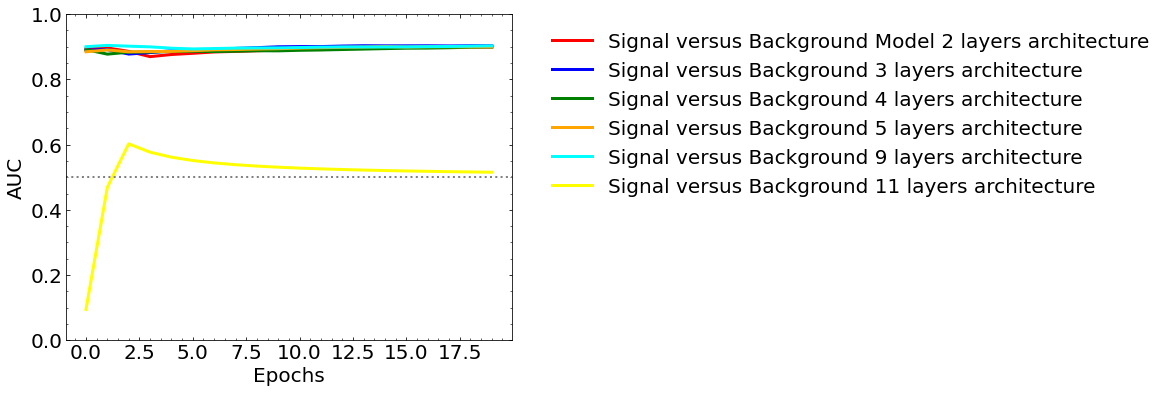

In [54]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(num_epochs, aucs_2lay,label="Signal versus Background Model 2 layers architecture",linewidth=3,color='red')
#plt.plot(num_epochs, aucsSB_2lay,label="Background in SR versus SB 2 layers architecture",ls="--",linewidth=3,color='red')

plt.plot(num_epochs, aucs_3lay,label="Signal versus Background 3 layers architecture",linewidth=3,color='blue')
#plt.plot(num_epochs, aucsSB_3lay,label="Background in SR versus SB 3 layers architecture",ls="--",linewidth=3,color='blue')

plt.plot(num_epochs, aucs_4lay,label="Signal versus Background 4 layers architecture",linewidth=3,color='green')
#plt.plot(num_epochs, aucsSB_4lay,label="Background in SR versus SB 4 layers architecture",ls="--",linewidth=3,color='green')

plt.plot(num_epochs, aucs_5lay,label="Signal versus Background 5 layers architecture",linewidth=3,color='orange')
#plt.plot(num_epochs, aucsSB_5lay,label="Background in SR versus SB 5 layers architecture",ls="--",linewidth=3,color='orange')

plt.plot(num_epochs, aucs_9lay,label="Signal versus Background 9 layers architecture",linewidth=3,color='cyan')
#plt.plot(num_epochs, aucsSB_9lay,label="Background in SR versus SB 9 layers architecture",ls="--",linewidth=3,color='cyan')

plt.plot(num_epochs, aucs_11lay,label="Signal versus Background 11 layers architecture",linewidth=3,color='yellow')
#plt.plot(num_epochs, aucsSB_11lay,label="Background in SR versus SB 11 layers architecture",ls="--",linewidth=3,color='yellow')

#plt.plot(num_epochs, aucs_15lay,label="Signal versus Background 15 layers architecture",linewidth=3,color='magenta')
#plt.plot(num_epochs, aucsSB_15lay,label="Background in SR versus SB 15 layers architecture",ls="--",linewidth=3,color='magenta')



plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'Epochs',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20, bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()
plt.ylim([0,1])

In [55]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbT21, bg2_srsbT21, sig_srsbT21 = sr_crit(dataset_bgT21), sr_crit(dataset_bg2T21), sr_crit(dataset_sigT21)

SR_background_dataT21 = dataset_bgT21[bg_srsbT21]
SB_background_dataT21 = dataset_bgT21[~bg_srsbT21]

SR_background_simT21 = dataset_bg2T21[bg2_srsbT21]
SB_background_simT21 = dataset_bg2T21[~bg2_srsbT21]

SR_signalT21 = dataset_sigT21[sig_srsbT21]
SB_signalT21 = dataset_sigT21[~sig_srsbT21]

N_inputs = len(SR_background_dataT21.T) - 1


((SR_background_dataT21, SR_background_data_fortestT21),
 (SR_background_simT21, SR_background_sim_fortestT21),
 (SB_background_dataT21, SB_background_data_fortestT21),
 (SB_background_simT21, SB_background_sim_fortestT21),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_dataT21, SR_background_simT21,
    SB_background_dataT21, SB_background_simT21,
]]

mn,mx = np.percentile(np.concatenate([SB_background_dataT21, SB_background_simT21, SR_background_dataT21, 
                                      SR_background_simT21]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalT21)*Nsig/len(SR_signalT21)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)**0.5))
print(fmt.format('s/b ratio', len(SR_signalT21[0:Nsig])/len(SR_background_dataT21)))

n_injectionsT21 = 20
SR_signals_to_injectT21 = [None] * n_injectionsT21
SB_signals_to_injectT21 = [None] * n_injectionsT21
signals_to_testT21 = [None] * n_injectionsT21

for i in range(n_injectionsT21):
    idx = np.isin(range(len(SR_signalT21)), np.random.choice(SR_signalT21.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectT21[i] = SR_signalT21[idx, :]
    signals_to_testT21[i] = SR_signalT21[~idx, :]
    
    idx = np.isin(range(len(SB_signalT21)), np.random.choice(SB_signalT21.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectT21[i] = SB_signalT21[idx, :]

     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


In [56]:
#CWoLa with T21 and relu 
cwola_rocsT21 = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injectionsT21)):
    
    SR_signal_to_injectT21 = SR_signals_to_injectT21[i]
    SB_signal_to_injectT21 = SB_signals_to_injectT21[i]

    signal_to_testT21 = signals_to_testT21[i]
        
    X_cwola_trainT21 = np.concatenate([SR_signal_to_injectT21, SR_background_dataT21, SB_signal_to_injectT21, SB_background_dataT21])
    Y_cwola_trainT21 = np.concatenate([np.ones(len(SR_signal_to_injectT21)), np.ones(len(SR_background_dataT21)),
                                    np.zeros(len(SB_signal_to_injectT21)), np.zeros(len(SB_background_dataT21))])
    
    X_cwola_trainT21, Y_cwola_trainT21 = shuffle(X_cwola_trainT21, Y_cwola_trainT21, )

    sbmjjT21 = X_cwola_trainT21[:,0]
    sb_critT21 = ((sbmjjT21 > SR_low - SB_width)&(sbmjjT21 <= SR_high + SB_width))
    
    X_cwola_trainT21 = X_cwola_trainT21[sb_critT21]
    Y_cwola_trainT21 = Y_cwola_trainT21[sb_critT21]
    
    w_lowT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] <= SR_low).sum())
    w_highT21 = 0.5*(len(SR_signal_to_injectT21) + len(SR_background_dataT21))/((X_cwola_trainT21[:,0] >= SR_high).sum())

    W_cwola_trainT21 = np.ones_like(Y_cwola_trainT21)
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] <= SR_low)] = w_lowT21
    W_cwola_trainT21[(Y_cwola_trainT21 == 0) & (X_cwola_trainT21[:,0] >= SR_high)] = w_highT21
    
    X_cwola_valT21 = np.concatenate([signal_to_testT21,SR_background_data_fortestT21])
    Y_cwola_valT21 = np.concatenate([np.ones(len(signal_to_testT21)),np.zeros(len(SR_background_data_fortestT21))])
    
    K.clear_session()
    model_cwolaT21 = Sequential()
    model_cwolaT21.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwolaT21.add(Dense(100, activation='relu'))
    model_cwolaT21.add(Dense(64, activation='relu'))
    model_cwolaT21.add(Dense(100, activation='relu'))
    model_cwolaT21.add(Dense(1, activation='sigmoid'))
    model_cwolaT21.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwolaT21 = model_cwolaT21.fit(X_cwola_trainT21[:,1:], Y_cwola_trainT21, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_trainT21)

    scores_cwolaT21 = model_cwolaT21.predict(X_cwola_valT21[:,1:],batch_size=batch_size)
        
    fpr_cwolaT21, tpr_cwolaT21, _ = roc_curve(Y_cwola_valT21, scores_cwolaT21)
    cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:35<30:08, 95.19s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [03:10<28:35, 95.28s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:45<26:56, 95.09s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [06:21<25:27, 95.48s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:57<23:56, 95.76s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [09:33<22:20, 95.75s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [11:07<20:38, 95.25s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [12:43<19:05, 95.46s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [14:21<17:39, 96.27s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 50%|████████████████████████████████████▌                                    | 10/20 [11:24:20<34:39:27, 12476.78s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 55%|████████████████████████████████████████▋                                 | 11/20 [11:26:01<21:43:21, 8689.00s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 60%|████████████████████████████████████████████▍                             | 12/20 [11:27:38<13:30:03, 6075.48s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 65%|████████████████████████████████████████████████▊                          | 13/20 [11:29:30<8:18:01, 4268.76s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 70%|████████████████████████████████████████████████████▌                      | 14/20 [11:31:25<5:01:25, 3014.25s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 75%|████████████████████████████████████████████████████████▎                  | 15/20 [11:33:26<2:58:30, 2142.14s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 80%|████████████████████████████████████████████████████████████               | 16/20 [11:35:41<1:42:31, 1537.80s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████▍           | 17/20 [11:37:47<55:40, 1113.49s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [11:39:44<27:07, 813.85s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
 95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [11:41:44<10:05, 605.53s/it]

675/675 [==============================] - 1s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_24580\1108918247.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocsT21 = cwola_rocsT21.append({'fpr': fpr_cwolaT21, 'tpr': tpr_cwolaT21}, ignore_index=True)
100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [11:43:47<00:00, 2111.38s/it]


In [57]:
 with np.errstate(divide='ignore'):
    tpr_pts = np.linspace(0, 1, 10000)
    
    # CWoLa T21
    fpr_interp = [None] * len(cwola_rocsT21)

    for i, row in cwola_rocsT21.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_maxT21 = np.nanmax(fpr_interp, axis=0).data
    cwola_minT21 = np.nanmin(fpr_interp, axis=0).data
    cwola_medT21 = np.median(fpr_interp, axis=0).data
    cwola_meanT21 = np.nanmean(fpr_interp, axis=0).data
    cwola_stdT21 = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smeanT21 = np.nanmean(sig_interp, axis=0).data
    cwola_sstdT21 = np.nanstd(sig_interp, axis=0).data
    
    
   

C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [58]:
bands_T21 = {'cwola_T21': (cwola_maxT21, cwola_medT21, cwola_minT21, cwola_meanT21, cwola_stdT21, cwola_smeanT21, cwola_sstdT21, {'label':'$T_{21}$', 'color':'blue'}),}